# Quora
    I have text data sets of quora questions and target variable denoting the sincerity of the question.
        Train Data Set Size: 1.3M
        Test Data Set Size: 375K
    
    The goal is to classify if the question is insincere from the text.
    
    Methods Used:
        Preprocessing and cleaning texts using word embeddings
        EDA
        Models:
            Base Model of Logistic Regression using TFIDF Matrix
            Neural Networks using Word embeddings
        Accuracy Metric: F1-score of target label '1'
    
    F1-Scores:
        Logistic: 0.59
        Keras: 0.66
### Importing Libraries and Data Sets

In [1]:
import pandas as pd
import numpy as np
import keras
import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
import pickle
import time
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
import json
import string
from pandas.io.json import json_normalize

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud, STOPWORDS
import operator

from keras.models import Model
from keras.layers import Dense, Embedding, Bidirectional, CuDNNGRU, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Input, Dropout,GRU,CuDNNLSTM,LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import model_from_json
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")
df = pd.concat([train ,test])
df['lowered_question'] = df['question_text'].apply(lambda x: x.lower())
print(train.shape)
print(test.shape)
train.head(5)

(1306122, 3)
(375806, 2)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


### Various Functions used in further operations

In [3]:
### N-Gram generation ###
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

### Horizontal bar chart ###
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

### Process Embeddings ###
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

### Building Vocab ###
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

### Checking the coverage of the vocab in Embeddings ###
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

### Adding words to embedding for which the embeddings doesn't have the lowercase version ###
def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")
    
### Checking the known contractions used in texts ###
def known_contractions(embed):
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known

### Mapping the contractions with its respective substituion ###
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

### Checking the punctuations not used in text ###
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

### Segmenting and Mapping the special charecters with its respection substitution ###
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

### Replacing the wrong spelling of a word with its correction ###
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

### Processing Data for Keras Model ###
def make_data(X):
    t = Tokenizer(num_words=len_voc)
    t.fit_on_texts(X)
    X = t.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=max_len)
    return X, t.word_index

### Making a matrix of the embeddings to be used in the Keras Model ###
def make_embed_matrix(embeddings_index, word_index, len_voc):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

### Finding the threshold to maximize F1 score ###
def tweak_threshold(pred, truth):
    thresholds = []
    scores = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        thresholds.append(thresh)
        score = f1_score(truth, (pred>thresh).astype(int))
        scores.append(score)
    return np.max(scores), thresholds[np.argmax(scores)]

### F1 Score calculation for Keras ###
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Ploting Word Cloud

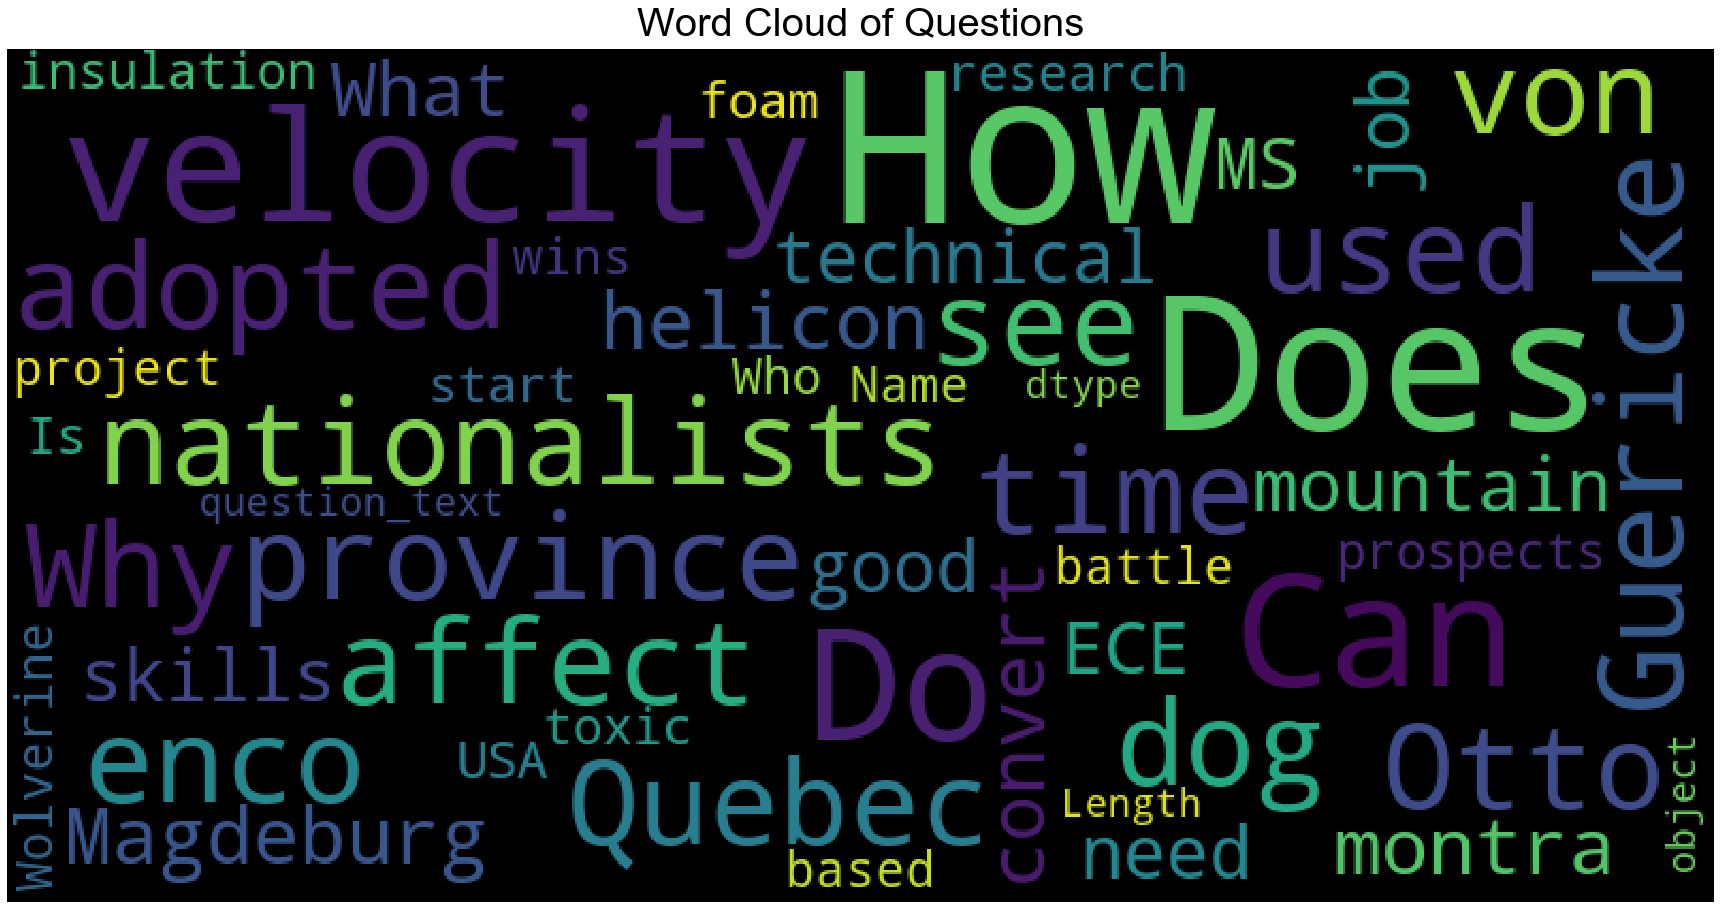

In [4]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train["question_text"], title="Word Cloud of Questions")

### The Data Set seems to be imbalanced

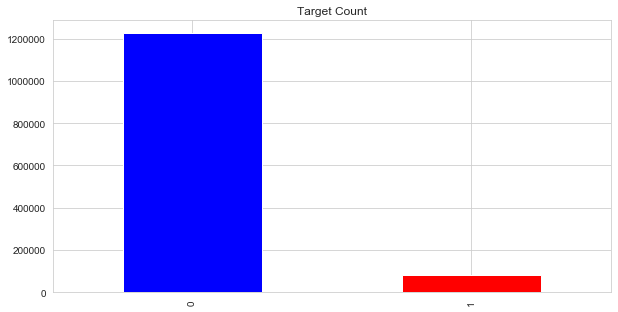

In [5]:
train['target'].value_counts().plot(kind='bar',title='Target Count',color=['blue','red'],figsize=(10,5))

### Different types of N-Grams and its count

In [6]:
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]

### Get the bar chart from sincere questions ###
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

### Get the bar chart from insincere questions ###
freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

### Creating two subplots ###
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

In [7]:
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions", 
                                          "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

In [8]:
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of sincere questions", 
                                          "Frequent trigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

### Processing and cleaning Text using Word Embeddings

In [9]:
### Loading the embedding into a dictonary ###

embed_glove = load_embed('input/embeddings/glove.840B.300d/glove.840B.300d.txt')

In [10]:
### Building Vocab (Words in the corpus and its count) ###

vocab = build_vocab(df['question_text'])

In [11]:
### Checkign Coverage and adding words to embedding for which the embeddings doesn't have the lowercase version ###

print('Coverage:')
oov_glove = check_coverage(vocab, embed_glove)
print('--------------------')
add_lower(embed_glove, vocab)
print('--------------------')
print('Coverage:')
oov_glove = check_coverage(vocab, embed_glove)

Coverage:
Found embeddings for 31.537% of vocab
Found embeddings for  88.155% of all text
--------------------
Added 17744 words to embedding
--------------------
Coverage:
Found embeddings for 31.820% of vocab
Found embeddings for  88.171% of all text


In [12]:
### Mapping contractions with its substitution and checing the coverage ###

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
print("Known Contractions:")
print(known_contractions(embed_glove))

df['treated_question'] = df['lowered_question'].apply(lambda x: clean_contractions(x, contraction_mapping))

print('--------------------')
print('Coverage:')
vocab = build_vocab(df['treated_question'])
oov_glove = check_coverage(vocab, embed_glove)

Known Contractions:
["can't", "'cause", "didn't", "doesn't", "don't", "I'd", "I'll", "I'm", "I've", "i'd", "i'll", "i'm", "i've", "it's", "ma'am", "o'clock", "that's", "you'll", "you're"]
--------------------
Coverage:
Found embeddings for 29.302% of vocab
Found embeddings for  88.570% of all text


In [13]:
### Mapping punctuations with its substitution and checing the coverage ###

punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }
print('Unknown punctuations:')
print(unknown_punct(embed_glove, punct))

df['treated_question'] = df['treated_question'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

print('--------------------')
print('Coverage:')
vocab = build_vocab(df['treated_question'])
oov_glove = check_coverage(vocab, embed_glove)

Unknown punctuations:
“ ” ’ ∞ θ ÷ α • à − β ∅ ³ π ‘ ₹ ´ ° £ € × ™ √ ² — – 
--------------------
Coverage:
Found embeddings for 66.961% of vocab
Found embeddings for  99.580% of all text


In [14]:
### Mapping mispelled words with its correction and checing the coverage ###

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}
df['treated_question'] = df['treated_question'].apply(lambda x: correct_spelling(x, mispell_dict))

print('Coverage:')
vocab = build_vocab(df['treated_question'])
oov_glove = check_coverage(vocab, embed_glove)

Coverage:
Found embeddings for 66.958% of vocab
Found embeddings for  99.582% of all text


In [15]:
del vocab,oov_glove

In [16]:
### Lowercasing ###
train['treated_question'] = train['question_text'].apply(lambda x: x.lower())
test['treated_question'] = test['question_text'].apply(lambda x: x.lower())
### Treating Contractions ###
train['treated_question'] = train['treated_question'].apply(lambda x: clean_contractions(x, contraction_mapping))
test['treated_question'] = test['treated_question'].apply(lambda x: clean_contractions(x, contraction_mapping))
### Treating Special characters ###
train['treated_question'] = train['treated_question'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))
test['treated_question'] = test['treated_question'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))
### Treating Spelling mistakes ###
train['treated_question'] = train['treated_question'].apply(lambda x: correct_spelling(x, mispell_dict))
test['treated_question'] = test['treated_question'].apply(lambda x: correct_spelling(x, mispell_dict))

### Building Baseline Logistic Model

In [17]:
### Extracting the TFIDF vectors ####

tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit_transform(train['treated_question'].values.tolist() + test['treated_question'].values.tolist())
train_tfidf = tfidf_vec.transform(train['treated_question'].values.tolist())
test_tfidf = tfidf_vec.transform(test['treated_question'].values.tolist())

In [18]:
### Spliting data and training model ###

y = train["target"].values
X_train, X_test, y_train, y_test = train_test_split(train_tfidf, y, test_size=0.1, random_state=42,stratify=y)
lr = linear_model.LogisticRegression(C=5., solver='sag')
lr.fit(X_train, y_train)

LogisticRegression(C=5.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
### Testing the performance ###

y_pred = lr.predict_proba(X_test)[:,1]

score_val, threshold_val = tweak_threshold(y_pred, y_test)
print(f"Scored {round(score_val, 4)} for threshold {threshold_val} with untreated texts on validation data")
print('--------------------')
print('Confusion Matrix:')
print(confusion_matrix(y_test,(y_pred>threshold_val).astype(int)))
print('--------------------')
print('Classification Report:')
print(classification_report(y_test,(y_pred>threshold_val).astype(int)))

Scored 0.594 for threshold 0.17 with untreated texts on validation data
--------------------
Confusion Matrix:
[[117761   4771]
 [  2652   5429]]
--------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    122532
           1       0.53      0.67      0.59      8081

    accuracy                           0.94    130613
   macro avg       0.76      0.82      0.78    130613
weighted avg       0.95      0.94      0.95    130613



### Buliding the Deep Learning Model
    Using Neural Nets on Word Embeddings

In [20]:
### Preparing Data and Embeddings for Keras ###

X, word_index = make_data(train['question_text'])
y = train['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)

embedding = make_embed_matrix(embed_glove, word_index, len_voc)

In [21]:
### Setting Variables ###

len_voc = 95000
max_len = 60

In [22]:
### Building Keras Model ###

inp    = Input(shape=(max_len,))
x      = Embedding(len_voc, 300, weights=[embedding], trainable=False)(inp)
x      = Bidirectional(GRU(128, return_sequences=True))(x)
x      = Bidirectional(GRU(64, return_sequences=True))(x)
avg_pl = GlobalAveragePooling1D()(x)
max_pl = GlobalMaxPooling1D()(x)
concat = concatenate([avg_pl, max_pl])
dense  = Dense(64, activation="relu")(concat)
drop   = Dropout(0.1)(concat)
output = Dense(1, activation="sigmoid")(concat)

model  = Model(inputs=inp, outputs=output)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy', f1])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 300)      28500000    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 256)      329472      embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 60, 128)      123264      bidirectional_1[0][0]            
____________________________________________________________________________________________

In [23]:
### Training the Model ###

epochs = 8
batch_size = 512
checkpoints = ModelCheckpoint('weights.hdf5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.000001)

In [24]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=[X_val, y_val], callbacks=[checkpoints, reduce_lr])

Train on 1175509 samples, validate on 130613 samples
Epoch 1/8
1175509/1175509 [==============================] - 710s 604us/step - loss: 0.1298 - accuracy: 0.9505 - f1: 0.4697 - val_loss: 0.1167 - val_accuracy: 0.9537 - val_f1: 0.5324

Epoch 00001: val_f1 improved from -inf to 0.53237, saving model to weights.hdf5
Epoch 2/8
1175509/1175509 [==============================] - 821s 698us/step - loss: 0.1122 - accuracy: 0.9555 - f1: 0.5780 - val_loss: 0.1122 - val_accuracy: 0.9560 - val_f1: 0.6255

Epoch 00002: val_f1 improved from 0.53237 to 0.62547, saving model to weights.hdf5
Epoch 3/8
1175509/1175509 [==============================] - 846s 719us/step - loss: 0.1073 - accuracy: 0.9575 - f1: 0.6041 - val_loss: 0.1061 - val_accuracy: 0.9582 - val_f1: 0.5998

Epoch 00003: val_f1 did not improve from 0.62547

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/8
1175509/1175509 [==============================] - 851s 724us/step - loss: 0.1037 - accuracy

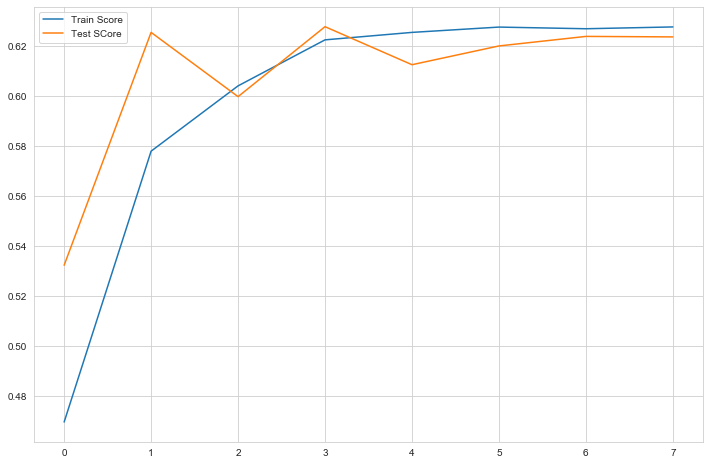

In [25]:
plt.figure(figsize=(12,8))
plt.plot(history.history['f1'], label='Train Score')
plt.plot(history.history['val_f1'], label='Test SCore')
plt.legend()
plt.show()

In [26]:
### Testing the performance ###

y_pred = model.predict(X_val, batch_size=512, verbose=1)

print('--------------------')
score_val, threshold_val = tweak_threshold(y_pred, y_test)
print(f"Scored {round(score_val, 4)} for threshold {threshold_val} with untreated texts on validation data")
print('--------------------')
print('Confusion Matrix:')
print(confusion_matrix(y_test,(y_pred>threshold_val).astype(int)))
print('--------------------')
print('Classification Report:')
print(classification_report(y_test,(y_pred>threshold_val).astype(int)))

130613/130613 [==============================] - 16s 123us/step
--------------------
Scored 0.659 for threshold 0.34 with untreated texts on validation data
--------------------
Confusion Matrix:
[[119134   3398]
 [  2440   5641]]
--------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    122532
           1       0.62      0.70      0.66      8081

    accuracy                           0.96    130613
   macro avg       0.80      0.84      0.82    130613
weighted avg       0.96      0.96      0.96    130613

